In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)
from IPython.core.pylabtools import figsize
figsize(11, 5)
colores = ["#348ABD", "#A60628","#06A628"]


In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

# Algoritmo de entrenamiento por retropropagación (*backpropagation*)

## Un ejemplo de Geoffrey Hinton
Ejemplo tomado de:
"Aprendiendo representaciones distribuidas de conceptos" en

http://www.cogsci.ucsd.edu/~ajyu/Teaching/Cogs202_sp12/Readings/hinton86.pdf

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.408.7684&rep=rep1&type=pdf

<img src="figuras/ArbolGenealogico.png"/>

Relaciones:
  * hijo
  * hija
  * sobrino
  * sobrina
  * padre
  * madre
  * tío
  * tía
  * hermano
  * hermana
  * esposo
  * esposa
  
Proposiciones:
  * (colin tiene-padre james)
  * (colin tiene-madre victoria)
  * (james tiene-esposa victoria)
  
Objetivo:
  Que la red siguiente indique la segunda persona de la tercia, dados los valores en las dos primeras posiciones.
  
Diseño de la red:
  1. Capa uno:
     * 24 neuronas de entrada, una para cada persona
     * 12 neuronas de entrada, una para cada relación
  2. Capa dos:
     * 6 neuronas conectadas con las 24 personas.
     * 6 neuronas conectadas con las 12 relaciones.
  3. Capa tres:
     * 12 neuronas conectadas a todas las neuronas en la capa 2.
  4. Capa cuatro:
     * 6 neuronas conectadas a todas las neuronas en la capa 3.
  5. Capa cinco:
     * 24 neuronas de salida, una para cada persona relacionada con la de entrada.
     
Datos de entrada:
  * 112 proposiciones, 100 utilizadas para entrenamiento, con 1500 pasadas.
  
<img src="figuras/RedHinton86.png"/>

In [3]:
import numpy as np

from RedHinton import data

@interact(index = (0, len(data.tercias) - 1))
def muestraRelacion(index):
    print(data.tercias[index])

interactive(children=(IntSlider(value=55, description='index', max=111), Output()), _dom_classes=('widget-inte…

In [4]:
# De todas las relaciones, eliminaremos la persona 2.
# Lo cual nos deja con:
print(len(data.unicas), " posibles entradas.")

104  posibles entradas.


In [5]:
# Las entradas distintas que quedan son:

@interact(index = (0, len(data.unicas) - 1))
def muestraRelacion(index):
    print(data.unicas[index])

interactive(children=(IntSlider(value=51, description='index', max=103), Output()), _dom_classes=('widget-inte…

In [6]:
# Pasar las relaciones a vectores de entrada numéricos para la red neuronal
# Tómese en cuenta que, para cada entrada, puede haber más de una respuesta.

total = data.total
Datos = data.Datos
Salidas = data.Salidas

personas = data.personas
relaciones = data.relaciones

print("Personas: ", personas)
print("Relaciones: ", relaciones)

Personas:  ['Christopher', 'Penelope', 'Andrew', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'James', 'Jennifer', 'Charles', 'Colin', 'Charlotte', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Gina', 'Emilio', 'Lucia', 'Marco', 'Angela', 'Tomaso', 'Alfonso', 'Sophia']
Relaciones:  ['tiene-esposa', 'tiene-esposo', 'tiene-padre', 'tiene-madre', 'tiene-hermano', 'tiene-hermana', 'tiene-hijo', 'tiene-hija', 'tiene-tio', 'tiene-tia', 'tiene-sobrino', 'tiene-sobrina']


In [7]:
# Funciones cómodas para pasar del código en las neuronas a la representación
# simbólica
def codificaPersona(persona):
    """ Devuele un vector columna con los valores de activación
    correspondientes a la persona solicitada.
    """
    codigo = np.zeros((len(personas), 1))
    codigo[personas.index(persona)] = 1
    return codigo

def decodificaPersona(codigoPersonas, threshold = 0.5):
    """ Devuelve la lista de personas indicadas por el código.
    """
    personas_decod = []
    for i, val in enumerate(codigoPersonas):
        if val >= threshold:
            personas_decod.append(personas[i])
    return personas_decod

def codificaRelacion(relacion):
    """ Devuele un vector columna con los valores de activación
    correspondientes a la persona solicitada.
    """
    codigo = np.zeros((len(relaciones), 1))
    codigo[relaciones.index(relacion)] = 1
    return codigo

def decodificaRelacion(codigoRel):
    """ Devuelve la lista de todas las relaciones indicadas
    por el código.
    """
    relaciones_decod = []
    for i, val in enumerate(codigoRel):
        if val >= 0.5:
            relaciones_decod.append(relaciones[i])
    return relaciones_decod

In [8]:
@interact(index = (0, len(personas) - 1))
def muestraCodigoPersona(index):
    print(personas[index], codificaPersona(personas[index]).T)

interactive(children=(IntSlider(value=11, description='index', max=23), Output()), _dom_classes=('widget-inter…

In [9]:
@interact(index = (0, len(relaciones) - 1))
def muestraCodigoRelacion(index):
    print(relaciones[index], codificaRelacion(relaciones[index]).T)

interactive(children=(IntSlider(value=5, description='index', max=11), Output()), _dom_classes=('widget-intera…

In [10]:
@interact(index = (0, total - 1))
def muestraCodigoSalida(index):
    print(decodificaPersona(Datos[index,0:len(personas)]),
          decodificaRelacion(Datos[index,len(personas):]))
    print(Datos[index])
    print(decodificaPersona(Salidas[index]))
    print(Salidas[index])

interactive(children=(IntSlider(value=51, description='index', max=103), Output()), _dom_classes=('widget-inte…

In [11]:
# Verificar que las personas estén bien codificadas en la pregunta
for i, relNum in enumerate(Datos):
    decod = decodificaPersona(relNum[0:len(personas)])
    if (decod[0] != data.unicas[i][0] or len(decod) > 1):
        raise Exception("Persona mal codificada ", unicas[i][0], decod)
    #print(unicas[i][0], decod)
    
# Verificar que las relaciones estén bien codificadas
for i, relNum in enumerate(Datos):
    decod = decodificaRelacion(relNum[len(personas):])
    if (decod[0] != data.unicas[i][1] or len(decod) > 1):
        raise Exception("Relación mal codificada ", unicas[i][1], decod)
    #print(unicas[i][1], decod)

In [12]:
# Utilizaremos 100 relaciones para el entrenamiento y dejaremos 4 para probar qué pasa.

# Asignar la semilla para que todos los números aleatorios generados sean siempre los mismos
np.random.seed(10)
from numpy.random import RandomState

rndState = RandomState(42)

# Elegimos 100 ejemplares, después de revolver los datos
permutacion = rndState.permutation(total)

m = 100
X = Datos[permutacion][0:m]
Y = Salidas[permutacion][0:m]

mTest = 4
XTest = Datos[permutacion][m:]
YTest = Salidas[permutacion][m:]

# Verificamos que 'tiene-tio' y 'tiene-tia' estén incluidos..

In [13]:
@interact(index = (0, m - 1))
def muestraCodigoSalida(index):
    print(decodificaPersona(X[index,0:len(personas)]),
          decodificaRelacion(X[index,len(personas):]))
    print(X[index])
    print(decodificaPersona(Y[index]))
    print(Y[index])

interactive(children=(IntSlider(value=49, description='index', max=99), Output()), _dom_classes=('widget-inter…

## Red neuronal multicapa

### Alimentación

Ya tenemos datos para realizar nuestros experimentos.  Procedamos a programar la evaluación de la red neuronal multicapa.

Comencemos por programar una función que evalúe la salida de una sección contigua de neuronas en una capa, dadas sus entradas.  Utilizando notación matricial, es posible evaluarlas todas en paralelo.

\begin{align}
 a_i^{(l+1)} &= g\left(\sum_j \theta_{i,j}^{(l)} a_j^{(l)}\right) \\
 g &= \frac{1}{1 + e^{-x}} \\
\end{align}
\begin{equation}
 \begin{bmatrix}
  a_0^{(l+1)} \\
  a_1^{(l+1)} \\
  ... \\
  a_{n'}^{(l+1)}
 \end{bmatrix} = g \left(
 \begin{bmatrix}
  \theta_{10}^{(l)} & ... & \theta_{1n}^{(l)} \\
  ... \\
  \\
  \theta_{n'0}^{(l)} & ... & \theta_{n'n}^{(l)} \\
 \end{bmatrix}
 \begin{bmatrix}
  a_0^{(l)} \\
  a_1^{(l)} \\
  ... \\
  a_n^{(l)}
 \end{bmatrix} \right)
\end{equation}

donde $a_i^{(l)}$ es el valor de activación de la neurona $i$ en la capa $l$ y $\theta_{ij}^{(l)}$ el peso del arista que conecta a la neurona $a_j^{(l)}$ con la neurona $a_i^{(l+1)}$.

La función de activación $g$ se evalúa sobre el vector, componente por componente.

In [14]:
# Programa una función que reciba un arreglo y devuelva
# un arreglo con la función logística evaluada
# componente por componente
def logistica(z):
    return 1 / (1 + np.exp(-z))

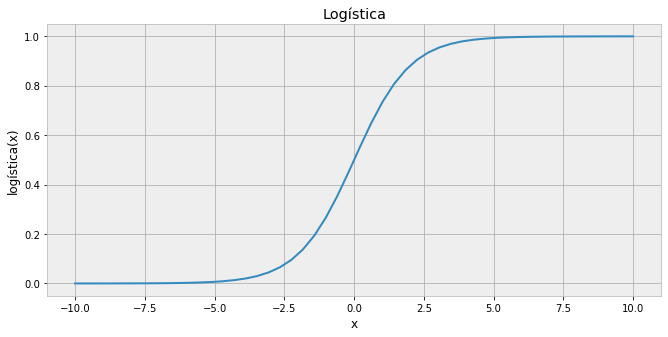

In [15]:
def plotLogistica():
    z = np.linspace(-10, 10)
    g = logistica(z)
    plt.title("Logística")
    plt.plot(z, g)
    plt.xlabel("x")
    plt.ylabel("logística(x)")
plotLogistica()

Ahora es necesario programar una función para evaluar los valores de activación de las neuronas en cada segmento de la red neuronal:

<img src="figuras/RedRelaciones.png" />



Observemos que el número de pesos conectando las diferentes capas son:
  * $W^{A1} \rightarrow (6 \times 24) = 144$
  * $W^{A2} \rightarrow (6 \times 12) = 72$
  * $W^{B1} \rightarrow (12 \times 6) = 72$
  * $W^{B2} \rightarrow (12 \times 6) = 72$
  * $W^{C} \rightarrow (6 \times 12) = 72$
  * $W^{D} \rightarrow (24 \times 6) = 144$
  
Lo cual da un total de **576** pesos, cuyo valor debe ser ajustado.

In [16]:
# Programa una función que reciba:
# los valores de activación de los grupos A1 y A2,
# las matrices de pesos WA1, WA2, WB1, WB2, WC y WD
# y devuelva la tupla (zb1, b_1, zb2, b_2, b, zc, c, zd, d, ze, e)
#
# Observa que, en este ejercicio, no hay entrada extra x_0 = 1.

def feedForward(self, a_1, a_2, vector = None):
    """ Dados los valores de activación para los bloques A1 y A2,
    calcula los valores de activación para cada capa hasta llegar
    a los valores de salida en E.
    
    Coloca cada vector de activación como una columna de una matriz.
    """
    self.a_1 = a_1
    self.a_2 = a_2
    
    if vector is None:
        Wa_1 = self.Wa_1
        Wa_2 = self.Wa_2
        Wb = self.Wb
        Wc = self.Wc
        Wd = self.Wd
    else:
        Wa_1, Wa_2, Wb, Wc, Wd = self.reconstructMatrices(vector)
    
    zb1 = np.dot(Wa_1, a_1)
    b_1 = logistica(zb1)
    
    zb2 = np.dot(Wa_2, a_2)
    b_2 = logistica(zb2)
    
    b = np.vstack((b_1, b_2))
    #print(b_1, b_2, b)
    #print(b_1.shape, b_2.shape, b.shape)
    zc = np.dot(Wb, b)
    c = logistica(zc)
    
    zd = np.dot(Wc, c)
    d = logistica(zd)
    
    ze = np.dot(Wd, d)
    e = logistica(ze)
    #print("Adelante:", zb1.shape, b_1.shape, zb2.shape, b_2.shape, b.shape, \
    #       zc.shape, c.shape, zd.shape, d.shape, ze.shape, e.shape)
    self.zb1, self.b_1, self.zb2, self.b_2, self.b, \
    self.zc, self.c, self.zd, self.d, self.ze, self.e = zb1, b_1, zb2, b_2, b, \
    zc, c, zd, d, ze, e

In [17]:
# Programemos una red neuronal utilizando el método anterior

class RedHinton:
    """
    Red Neuronal que deduce las relaciones de parentesco tomadas de árboles familiares
    ficticios.  Dada una persona y el tipo de relación de parentesco, es entrenada para
    devolver al pariente correspondiente.
    """
    def __init__(self, other = None):
        if other:
            """ Clona los pesos de 'other'."""
            self.Wa_1 = np.copy(other.Wa_1)
            self.Wa_2 = np.copy(other.Wa_2)
            self.Wb = np.copy(other.Wb)
            self.Wc = np.copy(other.Wc)
            self.Wd = np.copy(other.Wd)
            
    def __asignaPesos(Wa_1, Wa_2, Wb, Wc, Wd):
        """ Asigna los pesos indicados. """
        self.Wa_1 = Wa_1
        self.Wa_2 = Wa_2
        self.Wb = Wb
        self.Wc = Wc
        self.Wd = Wd
        
    def vectorWeights(self):
        """
        Acomoda a todos los parámetros en las matrices de pesos, en un solo vector.
        """
        vector = np.vstack((self.Wa_1.reshape((self.Wa_1.size, 1)),
                            self.Wa_2.reshape((self.Wa_2.size, 1)),
                            self.Wb.reshape((self.Wb.size, 1)),
                            self.Wc.reshape((self.Wc.size, 1)),
                            self.Wd.reshape((self.Wd.size, 1)),
                           ))
        return vector
    
    def reconstructMatrices(self, vector):
        """
        Dado un vector, rearma matrices del tamaño de las matrices de pesos.
        """
        first = 0
        last = self.Wa_1.size
        M0 = vector[first:last].reshape(self.Wa_1.shape)
        first = last
        last += self.Wa_2.size
        M1 = vector[first:last].reshape(self.Wa_2.shape)
        first = last
        last += self.Wb.size
        M2 = vector[first:last].reshape(self.Wb.shape)
        first = last
        last += self.Wc.size
        M3 = vector[first:last].reshape(self.Wc.shape)
        first = last
        last += self.Wd.size
        M4 = vector[first:last].reshape(self.Wd.shape)
        return M0, M1, M2, M3, M4
    
    def asignaUnosAPesos(self):
        """
        Asigna unos los pesos de todas las variables.
        Útil para pruebas iniciales.
        """
        self.Wa_1 = np.ones((6, 24))
        self.Wa_2 = np.ones((6, 12))
        self.Wb = np.ones((12, 12))
        self.Wc = np.ones((6, 12))
        self.Wd = np.ones((24, 6))
        
    def evalua(self, X):
        """ Evalúa la red sobre los ejemplares indicados
        y almacena los valores de activación de cada
        neurona.
        """
        self.a_1 = X[:,0:24].T
        self.a_2 = X[:,24:36].T
        self.feedForward(self.a_1, self.a_2)
        
setattr(RedHinton, 'feedForward', feedForward)

In [18]:
# Primera prueba al funcionamiento de la red
RH_0 = RedHinton()
RH_0.asignaUnosAPesos()
RH_0.evalua(X)

a_1 =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
a_2 =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
e =  [0.99752729 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729
 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729
 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729
 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729 0.99752729]
Lucia tiene-hija ['Christopher', 'Penelope', 'Andrew', 'Christine', 'Margaret', 'Arthur', 'Victoria', 'James', 'Jennifer', 'Charles', 'Colin', 'Charlotte', 'Roberto', 'Maria', 'Pierro', 'Francesca', 'Gina', 'Emilio', 'Lucia', 'Marco', 'Angela', 'Tomaso', 'Alfonso', 'Sophia']


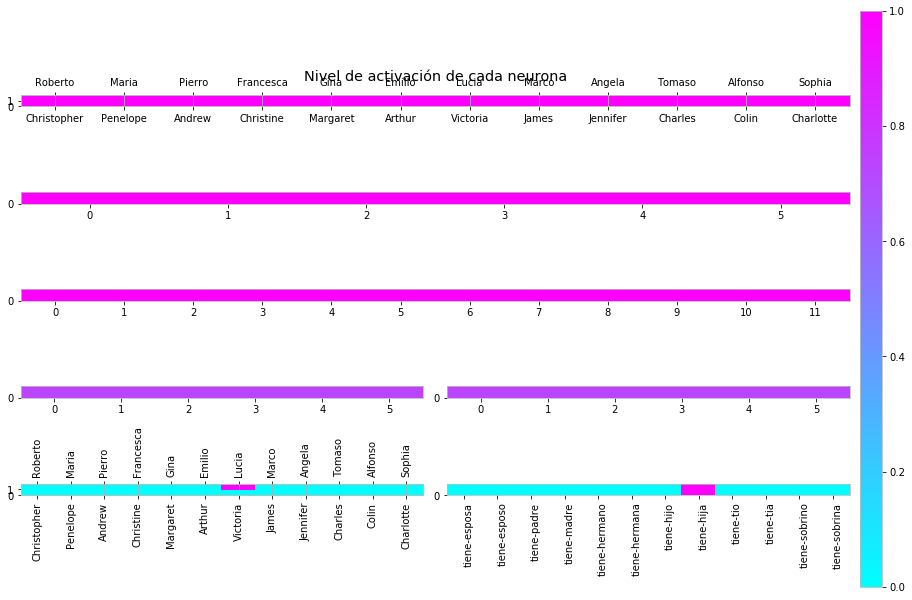

In [19]:
# Grafiquemos los valores de activación de cada neurona para una entrada dada.

from RedHinton.plot import *

def interpretaRespuesta(redHinton, iEntrada, printBits = False):
    """ Imprime la tercia, según las activaciones en la red. """
    if printBits:
        print("a_1 = ", redHinton.a_1[:,iEntrada])
        print("a_2 = ", redHinton.a_2[:,iEntrada])
        print("e = ", redHinton.e[:,iEntrada])
    p1 = decodificaPersona(redHinton.a_1[:,iEntrada])
    r = decodificaRelacion(redHinton.a_2[:,iEntrada])
    p2 = decodificaPersona(redHinton.e[:,iEntrada])
    
    print(" ".join(p1 + r), p2)
    
plotNetworkActivity(RH_0, 0)
interpretaRespuesta(RH_0, 0, True)

## Retroalimentación
Para entrenar a la red neuronal y calcular los pesos correctos automáticamente, utilizaremos el algoritmo de retroalimentación.

Como ejercicio inicial, ahora necesitaremos calcular el gradiente de la función de activación $g$.
\begin{align}
  \frac{dg}{dz} = g(z)\left(1-g(z)\right)
\end{align}

In [20]:
## Programa una función que, dado un arreglo de valores z
## calcule el valor de la derivada para cada entrada.

def derivadaLogistica(z):
    g = logistica(z)
    return g * (1 - g)

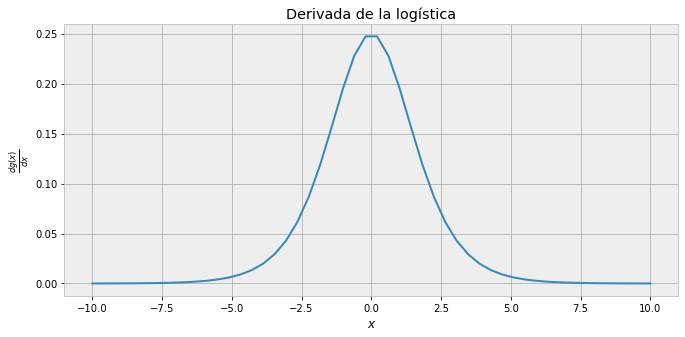

In [21]:
def plotDerivadaLogistica():
    z = np.linspace(-10, 10)
    gp = derivadaLogistica(z)
    plt.title("Derivada de la logística")
    plt.plot(z, gp)
    plt.xlabel("$x$")
    plt.ylabel("$\\frac{dg(x)}{dx}$")
plotDerivadaLogistica()

In [22]:
## Agreguemos un método a la neurona para que asigne pesos aleatorios.

def asignaPesosAleatorios(self):
    """
    Asigna pesos aleatorios a todas las conexiones.
    Útil para inicializar el entrenamiento.
    """
    epsilon_init = 0.6;
    self.Wa_1 = np.random.rand(6, 24) * 2 * epsilon_init - epsilon_init;
    self.Wa_2 = np.random.rand(6, 12) * 2 * epsilon_init - epsilon_init;
    self.Wb = np.random.rand(12, 12) * 2 * epsilon_init - epsilon_init;
    self.Wc = np.random.rand(6, 12) * 2 * epsilon_init - epsilon_init;
    self.Wd = np.random.rand(24, 6) * 2 * epsilon_init - epsilon_init;
setattr(RedHinton, 'asignaPesosAleatorios', asignaPesosAleatorios)

In [23]:
## Visualicemos el efecto para cada ejemplar
RH_A = RedHinton()
RH_A.asignaPesosAleatorios()

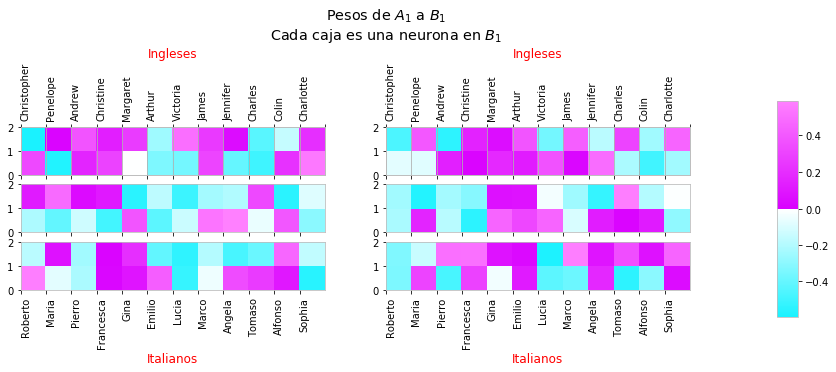

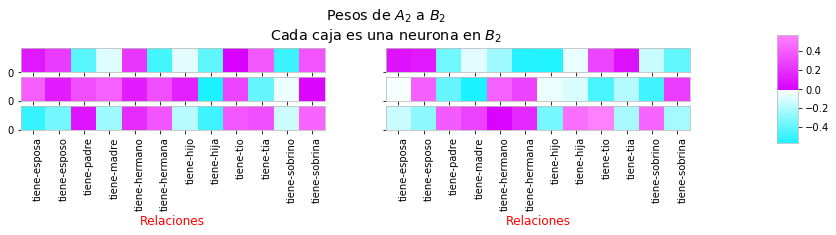

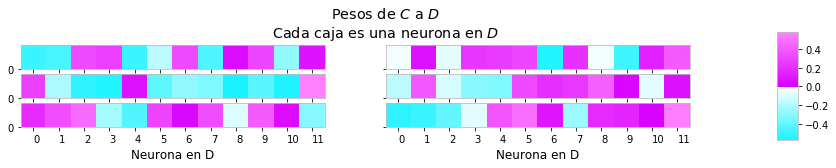

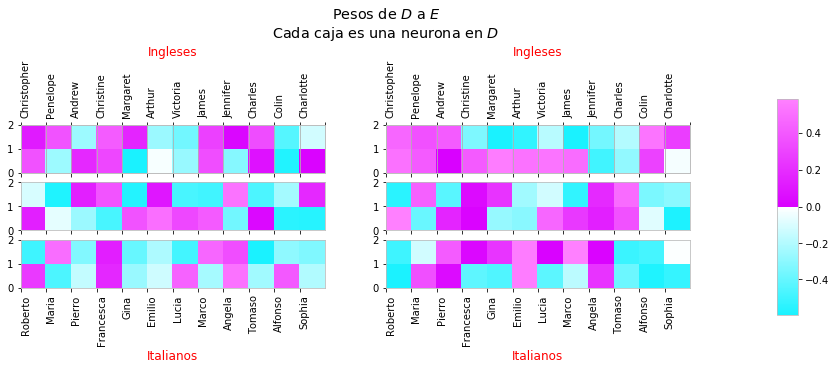

In [24]:
# Grafiquemos los valores de los pesos que conectan a las neuronas.
muestraPesos(RH_A)

In [25]:
RH_A.evalua(X)

@interact(index = (0, len(X)) )
def plotActivityTest(index):
    plotNetworkActivity(RH_A, index)
    interpretaRespuesta(RH_A, index, False)

interactive(children=(IntSlider(value=50, description='index'), Output()), _dom_classes=('widget-interact',))

### La función de error
Consideremos ahora a todos los ejemplares de entrenamiento, formando a la matriz $\mathbf{X}$, con cada renglón conteniendo las entradas de las neuronas en la primera capa, y las salidas para cada ejemplar en los renglones de la matriz $\mathbf{Y}$.
 \begin{align}
  \mathbf{X} &= \begin{bmatrix}
       x_0^{(1)} x_1^{(1)} ... x_{s_0}^{(1)}  \\
       x_0^{(2)} x_1^{(2)} ... x_{s_0}^{(2)}  \\
       ...\\
       x_0^{(m)} x_1^{(m)} ... x_{s_0}^{(m)}
      \end{bmatrix} &
  \mathbf{Y} &= \begin{bmatrix}
       y_0^{(1)} y_1^{(1)} ... y_{s_{L-1}}^{(1)}  \\
       y_0^{(2)} y_1^{(2)} ... y_{s_{L-1}}^{(2)}  \\
       ...\\
       y_0^{(m)} y_1^{(m)} ... y_{s_{L-1}}^{(m)}
      \end{bmatrix}
 \end{align}

En este ejemplo utilizaremos la misma función de error que utilizó Hinton, el error cuadrático:
\begin{align}
  E =& \frac{1}{2m} \sum_{i=0}^{M-1} \sum_{k=0}^{K-1} (y_{ik} - a_{ik})^2
\end{align}
donde:
  * $M$ es el número de ejemplares de entrenamiento y
  * $K$ es el número de neuronas de salida.

In [26]:
def error(self, X, Y, vector=None, cheat=True):
    """ Evalúa la red sobre X y calcula el error cuadrático."""
    m = len(X)
    
    # Ejecutar propagación hacia adelante para todos
    # los ejemplares en X
    self.a_1 = X[:,0:24].T
    self.a_2 = X[:,24:36].T
    self.feedForward(self.a_1, self.a_2, vector)
    
    # Calcular el error, con tolerancia
    e = self.e.copy()
    y = Y.copy()
    if cheat:
        e[e >= 0.8] = 0.8
        e[e <= 0.2] = 0.2
        y[y == 1] = 0.8
        y[y == 0] = 0.2
    
    # Calcular el error
    Delta_E = (y.T - e)
    # Suma sobre todas las clases y ejemplares
    Error = np.sum(Delta_E ** 2) / (2 * m)
    return (Error, Delta_E)
setattr(RedHinton, 'error', error)

In [27]:
def error_y_gradiente(self, Delta_E):
    """ Devuelve el valor del gradiente, es decir, los valores de las parciales
    con respecto a los pesos en las matrices.
    Al calcular el error debió haberse obtendio Delta_E, por lo que
    reutiliza, recibiendo el resultado como parámetro.
    """
    #Wa_1 = self.Wa_1
    #Wa_2 = self.Wa_2
    Wb = self.Wb
    Wc = self.Wc
    Wd = self.Wd
    
    # Dimensiones
    m = len(X)
    sL = Y.shape[1]
    
    Zb1 = self.zb1
    B_1 = self.b_1
    Zb2 = self.zb2
    B_2 = self.b_2
    B = self.b
    Zc = self.zc
    C = self.c
    Zd = self.zd
    D = self.d
    Ze = self.ze
    E = self.e
    
    # Derivadas con respecto a los pesos que conectan a D con E.
    Delta_D = Delta_E * derivadaLogistica(Ze)
    WD_grad = - np.dot(Delta_D, D.T) / m
    #print(Delta_D.shape, Zd.shape)
    
    # Derivadas con respecto a los pesos que conectan a C con D.
    Delta_C = np.dot(Delta_D.T, Wd)
    Delta_C = Delta_C.T * derivadaLogistica(Zd)
    WC_grad = - np.dot(Delta_C, C.T) / m
    
    # Derivadas con respecto a los pesos que conectan B con C.
    Zb = np.vstack((Zb1, Zb2))
    Delta_B = np.dot(Delta_C.T, Wc).T * derivadaLogistica(Zc)
    WB_grad = - np.dot(Delta_B, B.T) / m
    
    # Derivadas con respecto a los pesos que conectan A1 con B1.
    Zb1 = Zb[0:6,:]
    Wb1 = Wb[:,0:6]
    A1 = X[:,0:24].T
    Delta_A1 = np.dot(Delta_B.T, Wb1).T * derivadaLogistica(Zb1)
    WA_1_grad = -np.dot(Delta_A1, A1.T) / m
    
    Zb2 = Zb[6:,:]
    Wb2 = Wb[:,6:]
    A2 = X[:,24:36].T
    Delta_A2 = np.dot(Delta_B.T, Wb2).T * derivadaLogistica(Zb2)
    WA_2_grad = -np.dot(Delta_A2, A2.T) / m
    
    return (WA_1_grad, WA_2_grad, WB_grad, WC_grad, WD_grad)
setattr(RedHinton, 'error_y_gradiente', error_y_gradiente)

In [28]:
def approxGradient(self, X, Y):
    """
    Aproxima el valor del gradiente alrededor de los pesos actuales,
    perturbando cada valor, uno por uno.
    """
    vector = self.vectorWeights().copy()
    approx = np.zeros(vector.shape)
    perturb = np.zeros(vector.shape)
    epsilon = 0.0001

    for i in range(len(vector)):
        perturb[i] = epsilon
        loss1, trash = self.error(X, Y, vector - perturb)
        loss2, trash = self.error(X, Y, vector + perturb)
        perturb[i] = 0
        approx[i] = (loss2 - loss1) / (2 * epsilon)
    return approx
setattr(RedHinton, 'approxGradient', approxGradient)

In [29]:
def descensoGradiente(self, X, Y, alfa, ciclos = 50, alfaV = 0.0, weight_decay = 0.8, check=False):
    """ Ejecuta descenso por el gradiente, agregando las opciones
    momentum (cuya intensidad está dada por el parámetro alfaV) y weight_decay. """
    errores = np.zeros(ciclos)
    E = 0
    DWa_1 = 0
    DWa_2 = 0
    DWb = 0
    DWc = 0
    DWd = 0
    Comparacion = None
    for i in range(ciclos):
        E, Delta_E = self.error(X, Y)
        Wa_1_grad, Wa_2_grad, Wb_grad, Wc_grad, Wd_grad = self.error_y_gradiente(Delta_E)
        if check:
            #Wa_1_grad, Wa_2_grad, Wb_grad, Wc_grad, Wd_grad = self.approxGradient(X, Y)
            #ApproxWa_1, ApproxWa_2, ApproxWb, ApproxWc, ApproxWd = self.approxGradient(X, Y)
            Approx = self.approxGradient(X, Y)
            Grad = np.vstack((Wa_1_grad.reshape((Wa_1_grad.size, 1)),
                            Wa_2_grad.reshape((Wa_2_grad.size, 1)),
                            Wb_grad.reshape((Wb_grad.size, 1)),
                            Wc_grad.reshape((Wc_grad.size, 1)),
                            Wd_grad.reshape((Wd_grad.size, 1)),
                           ))
            opt = np.get_printoptions()
            np.set_printoptions(threshold=np.inf)
            Comparacion = np.hstack((Approx, Grad))
            np.set_printoptions(**opt)
        
        # Almacena el cambio al gradiente en este paso, nótese que es afectado por el cambio
        # en el paso anterior
        DWa_1 = - alfa * Wa_1_grad + alfaV * DWa_1
        DWa_2 = - alfa * Wa_2_grad + alfaV * DWa_2
        DWb = - alfa * Wb_grad + alfaV * DWb
        DWc = - alfa * Wc_grad + alfaV * DWc
        DWd = - alfa * Wd_grad + alfaV * DWd
        
        # Actualiza los pesos y reduce su magnitud
        self.Wa_1 = (self.Wa_1 + DWa_1) * weight_decay
        self.Wa_2 = (self.Wa_2 + DWa_2) * weight_decay
        self.Wb = (self.Wb + DWb) * weight_decay
        self.Wc = (self.Wc + DWc) * weight_decay
        self.Wd = (self.Wd + DWd) * weight_decay
        errores[i] = E
        
    x = np.arange(ciclos)
    print("Error final = ", E)
    if ciclos > 1:
        plt.title("Error")
        plt.xlabel("ciclo")
        plt.scatter(x, errores)
    if Comparacion is not None:
        return Comparacion
setattr(RedHinton, 'descensoGradiente', descensoGradiente)

In [30]:
comparacion = [None]
@interact_manual
def verificaImplementaconRetropropagacion():
    """ Ejecuta propagación hacia atrás y aproxima el gradiente con pequeñas perturbaciones. """
    RH_B = RedHinton(RH_A)
    global comparacion
    comparacion = RH_B.descensoGradiente(X, Y, 0.3, ciclos = 1, alfaV = 0.0, check=True)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [31]:
@interact(row = (0, len(comparacion) - 1))
def muestraComparacionComponentes(row):
    """ Si se ejecutó la celda anterior, muestra los valores del gradiente calculado con ambos
    métodos conexión por conexión en la red. """
    global comparacion
    print(comparacion[row])

interactive(children=(IntSlider(value=0, description='row', max=0), Output()), _dom_classes=('widget-interact'…

In [32]:
RH_B = RedHinton(RH_A)

Error final =  0.18441763171697503


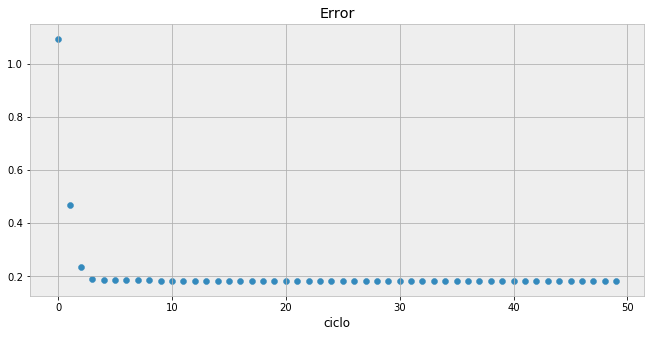

In [33]:
RH_B.descensoGradiente(X, Y, 5, ciclos = 50, alfaV = 0.0, weight_decay = 1.0)

In [34]:
@interact_manual()
def entrenaRH_B_Simple():
    RH_B.descensoGradiente(X, Y, 5, ciclos = 5730, alfaV = 0.0, weight_decay = 1.0)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [35]:
@interact_manual
def reinicia_red():
    """ Si el entrenamiento fue mal, ejecutar esta celda para volver al inicio. """
    RH_B = RedHinton(RH_A)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [36]:
#RH_B.descensoGradiente(X, Y, 0.005, ciclos = 1, alfaV = 0.5, check=True)

In [37]:
#RH_B.descensoGradiente(X, Y, 0.005, ciclos = 20, alfaV = 0.5)
#RH_B.descensoGradiente(X, Y, 0.01, ciclos = 553, alfaV = 0.9)

In [38]:
@interact_manual()
def entrenaRH_B_Fase1():
    RH_B.descensoGradiente(X, Y, 0.005, ciclos = 20, alfaV = 0.9, weight_decay = 1.0)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [39]:
@interact_manual()
def entrenaRH_B_Fase2():
    RH_B.descensoGradiente(X, Y, 5, ciclos = 5730, alfaV = 0.9, weight_decay = 1.0)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

<img width="400" src="figuras/ArbolGenealogico.png"/>

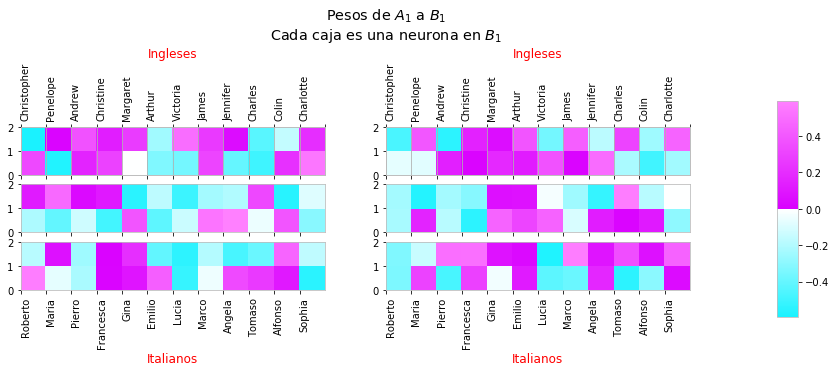

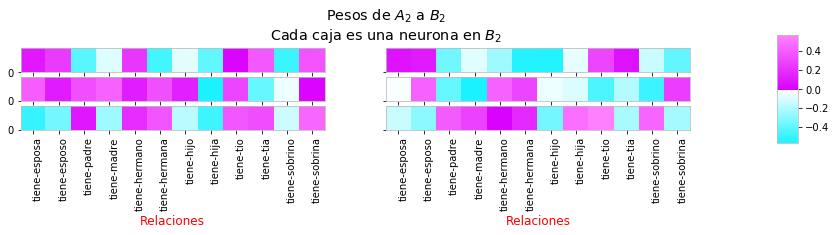

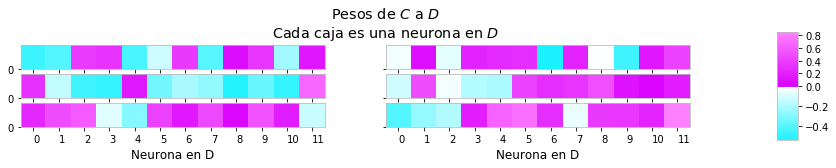

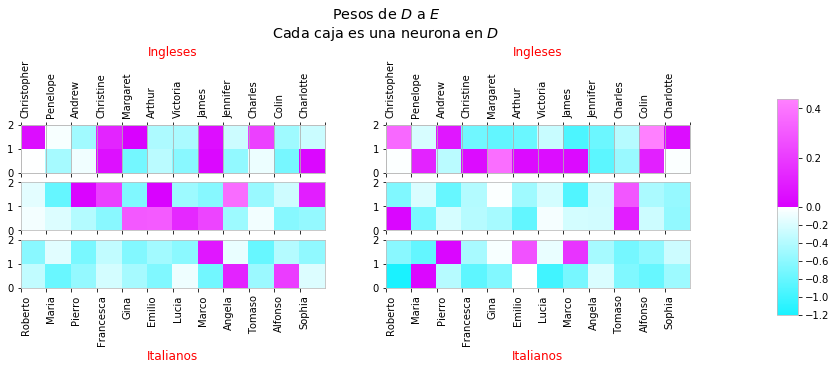

In [40]:
muestraPesos(RH_B)

In [41]:
#print(RH_B.Wa_1, RH_B.Wa_2, RH_B.Wd)

In [42]:
@interact(index = (0, len(Datos) - 1))
def plotActivityTest(index):
    RH_B.evalua(Datos[np.newaxis, index])
    plotNetworkActivity(RH_B, 0)
    interpretaRespuesta(RH_B, 0, False)
    print("Se esperaba ", decodificaPersona(Salidas[index]))

interactive(children=(IntSlider(value=51, description='index', max=103), Output()), _dom_classes=('widget-inte…

In [43]:
def responde(self, persona1, relacion, showBits = False):
    a_1 = codificaPersona(persona1)
    a_2 = codificaRelacion(relacion)
    X = np.vstack((a_1, a_2)).T
    self.evalua(X)
    personas2 = decodificaPersona(self.e)
    interpretaRespuesta(self, 0, showBits)
    return personas2
setattr(RedHinton, 'responde', responde)

In [44]:
RH_B.responde('Arthur', 'tiene-padre')

Arthur tiene-padre []


[]

In [45]:
# Desempeño en el conjunto de prueba
for i in range(mTest):
    persona1 = decodificaPersona(XTest[i][0:24])
    relacion = decodificaRelacion(XTest[i][24:])
    persona2 = decodificaPersona(YTest[i])
    persona2_res = RH_B.responde(persona1[0], relacion[0])
    print("Se esperaba ", persona2 , "\n")
    

Colin tiene-padre []
Se esperaba  ['James'] 

Roberto tiene-esposa []
Se esperaba  ['Maria'] 

Charlotte tiene-padre []
Se esperaba  ['James'] 

Emilio tiene-esposa []
Se esperaba  ['Gina'] 



# Evaluación

Como se puede ver en las gráficas anteriores, esta red aprendió a minimizar el error global, pero no aprendió a predecir quien(es) son las personas que deben aparecer en la tercera posición de la tupla.  ¡Nisiquiera para los datos de entrenamiento!  En unos momentos estudiaremos qué se puede hacer al respecto.

## Matriz de confusión
Para comenzar veremos qué tan mal está y a dónde llegó la red después del proceso de minimización.  Para ello se requiere una medida más eficiente que la función de error.  Calcularemos los valores de la matriz de confusión, comparando los valores deseados, contra los valores de salida en cada neurona de la última capa, después de aplicar un función umbral.

<table>
<thead>
<tr><th colspan="2"></th><th colspan="2">Clase predicha</th></tr>
<tr><th colspan="2"></th><th>1</th><th>0</th></tr>
</thead>
<tr><th rowspan="2">Clase correcta</th><th>1</th><td>TP</td><td>FN</td></tr>
<tr><th>0</th><td>FP</td><td>TN</td></tr>
</table>

In [46]:
def matrizDeConfusion(redHinton, X, Y):
    """ Calcula los elementos de la matriz de confusión,
    considerando las diferencias, neurona por neurona, entre
    la predicción obtenida (después de aplicar la función umbral)
    y la deseada, para cada ejemplar en (X, Y)
    """
    redHinton.evalua(X)
    
    thr = np.zeros(redHinton.e.shape)
    thr[redHinton.e >= 0.5] = 1
    thr = thr.T
    
    numElemems = Y.shape[0] * Y.shape[1]
    prediccion = thr.astype(bool)
    etiquetas = Y.astype(bool)
    
    matriz = np.zeros((2,2))
    TP = np.sum(np.logical_and(prediccion, etiquetas))
    matriz[0][0] = TP
    
    TN = np.logical_and(np.logical_not(prediccion), np.logical_not(etiquetas))
    matriz[1][1] = np.sum(TN)
    
    FP = np.logical_and(np.logical_not(etiquetas), prediccion)
    matriz[1][0] = np.sum(FP)
    
    FN = np.logical_and(etiquetas, np.logical_not(prediccion))
    matriz[0][1] = np.sum(FN)
    
    return matriz
matrizDeConfusion(RH_B, XTest, YTest)

array([[ 0.,  4.],
       [ 0., 92.]])

In [47]:
matrizDeConfusion(RH_B, X, Y)

array([[   0.,  108.],
       [   0., 2292.]])